In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

=== First 5 Rows ===
   _ID_EXAM  IMAGE_NAME  ID_PATIENT  CLASS_TYPE GENDER RIGH/LEFT-HANDED  AGE  \
0        68  0068-1.jpg           1           0      F                L   28   
1        68  0068-2.jpg           1           0      F                L   28   
2        68  0068-3.jpg           1           0      F                L   28   
3        68  0068-4.jpg           1           0      F                L   28   
4        92  0092-1.jpg           2           0      M                R   37   

           RMS  MAX_BETWEEN_ET_HT  MIN_BETWEEN_ET_HT  STD_DEVIATION_ET_HT  \
0  2446.759108        5388.771096       3.343540e+04                  0.0   
1  2159.220559        4617.939790       3.442829e+04                  0.0   
2  1740.390711        4260.973134       3.363295e+07                  0.0   
3  2047.900847        4286.241318       3.241294e+04                  0.0   
4  2059.220895        4733.016802       3.543708e+04                  0.0   

         MRT      MAX_HT    MIN_HT 

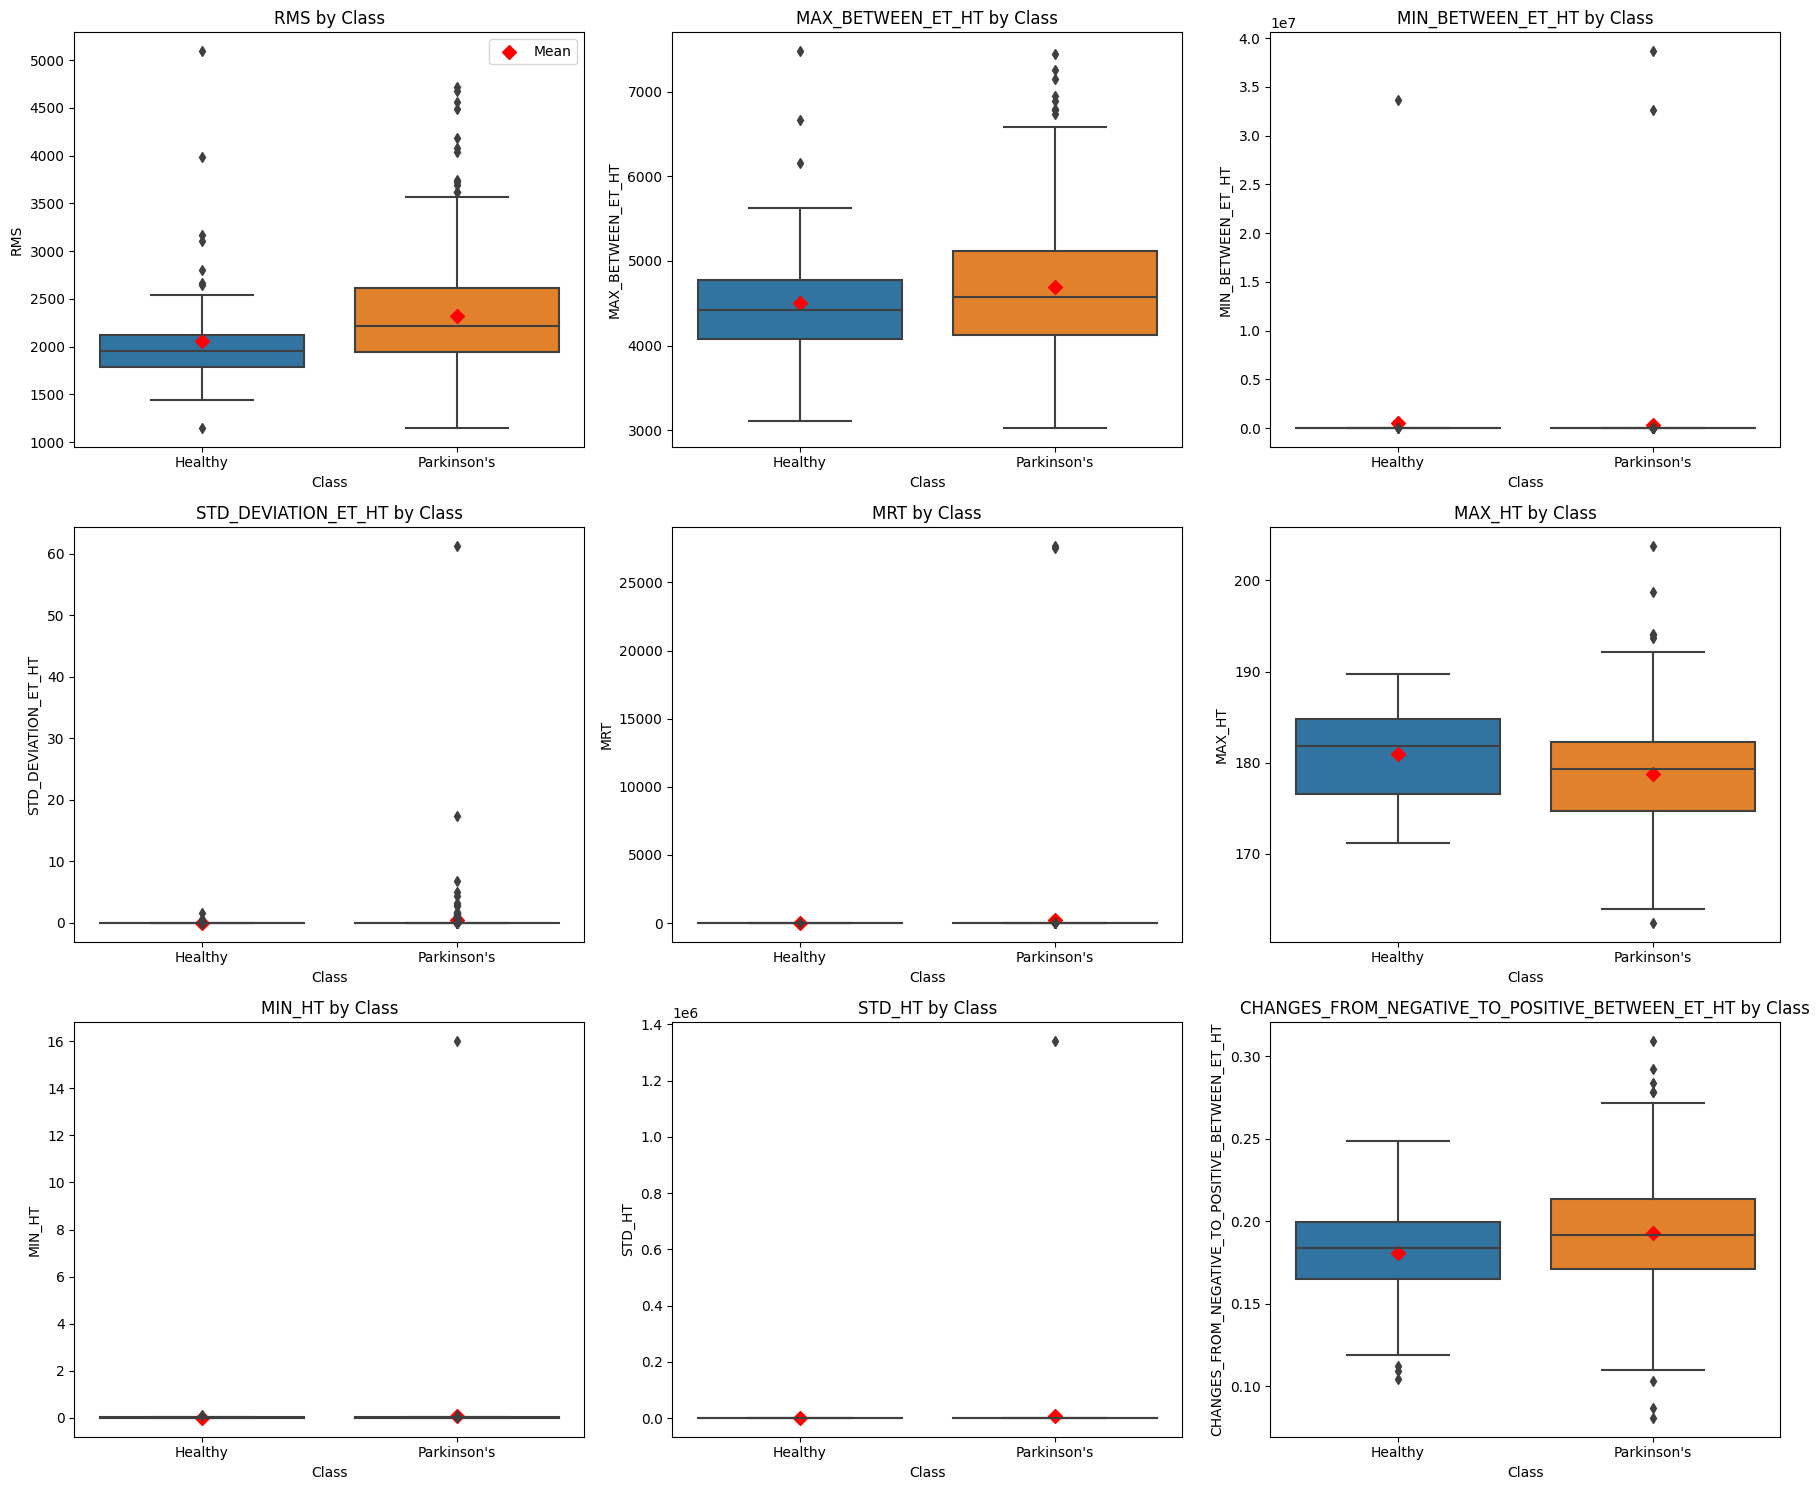

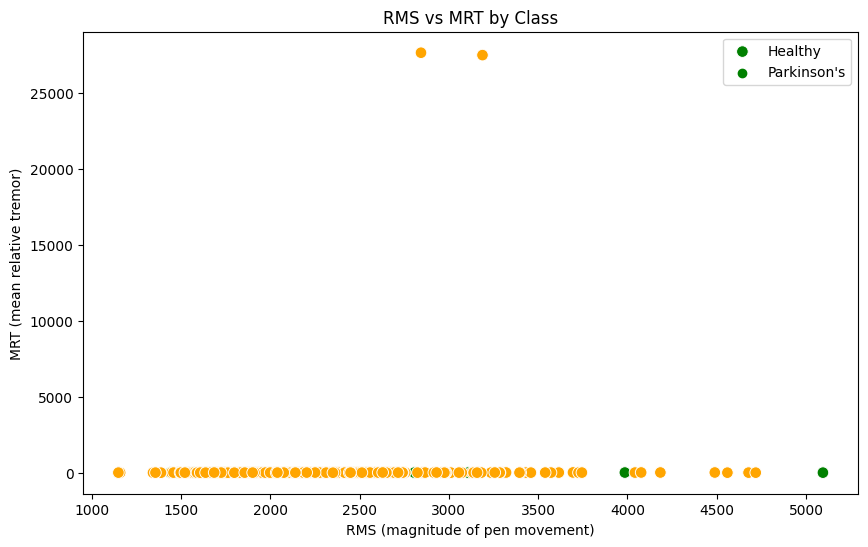


=== GroupKFold Cross-Validation ===

--- Fold 1 ---
F1 Score: 0.846, ROC AUC: 0.740
Confusion Matrix:
[[ 1 15]
 [ 5 55]]

--- Fold 2 ---
F1 Score: 0.913, ROC AUC: 0.746
Confusion Matrix:
[[ 1  7]
 [ 5 63]]

--- Fold 3 ---
F1 Score: 0.915, ROC AUC: 0.794
Confusion Matrix:
[[ 2 10]
 [ 1 59]]

--- Fold 4 ---
F1 Score: 0.836, ROC AUC: 0.611
Confusion Matrix:
[[ 1 19]
 [ 1 51]]

--- Fold 5 ---
F1 Score: 0.885, ROC AUC: 0.780
Confusion Matrix:
[[ 4 12]
 [ 2 54]]


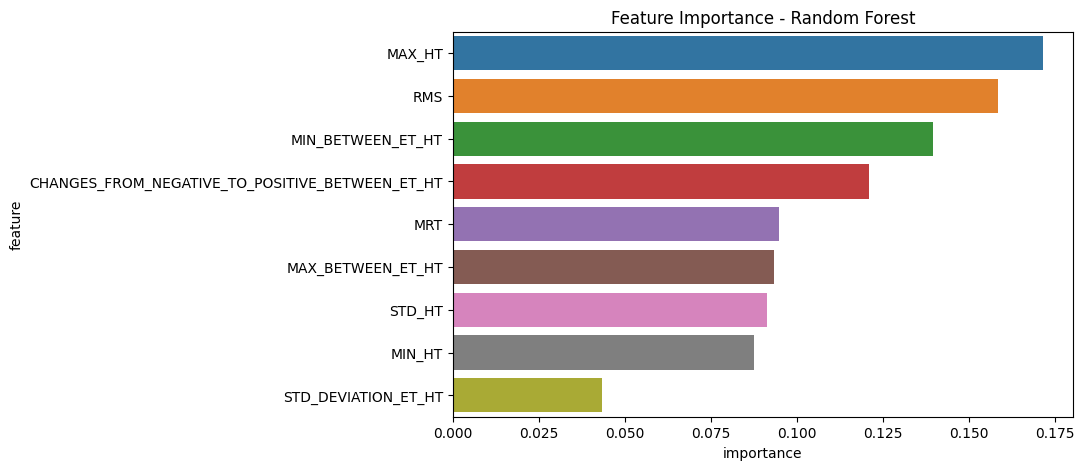


✅ Notebook complete! Dashboard, modeling, and feature importance ready.
=== Model Performance on Test Set ===
F1 Score: 0.908
ROC AUC: 0.704
Confusion Matrix:
 [[ 3 11]
 [ 1 59]]

=== Prediction for New Sample ===
Predicted class: Parkinson's
Probability: Healthy=0.24, Parkinson's=0.76


['handpd_model.pkl']

In [43]:
# ==============================
# Kaggle Notebook: Parkinson's Spiral HandPD Model (Cleaned & Warning-Free)
# ==============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

# ==============================
# Step 0: Load Dataset
# ==============================
spiral_df = pd.read_csv("/kaggle/input/spiral-handpd/Spiral_HandPD.csv")

# Map CLASS_TYPE: 0 = Healthy, 1 = Parkinson's
spiral_df['CLASS_TYPE'] = spiral_df['CLASS_TYPE'] - 1

# Define numeric features
numeric_features = [
    'RMS', 
    'MAX_BETWEEN_ET_HT', 
    'MIN_BETWEEN_ET_HT',
    'STD_DEVIATION_ET_HT', 
    'MRT', 
    'MAX_HT', 
    'MIN_HT', 
    'STD_HT', 
    'CHANGES_FROM_NEGATIVE_TO_POSITIVE_BETWEEN_ET_HT'
]

# ==============================
# Step 1: Data Exploration
# ==============================
print("=== First 5 Rows ===")
print(spiral_df.head())

print("\n=== Column Data Types ===")
print(spiral_df.dtypes)

print("\n=== Missing Values ===")
print(spiral_df.isnull().sum())

print("\n=== Numeric Feature Summary ===")
print(spiral_df[numeric_features].describe())

print("\n=== Class Distribution ===")
print(spiral_df['CLASS_TYPE'].value_counts())

# ==============================
# Step 2: Feature Visualization
# ==============================
# Boxplots with mean diamonds
num_features = len(numeric_features)
cols = 3
rows = int(np.ceil(num_features / cols))

plt.figure(figsize=(18, 5*rows))
for i, feature in enumerate(numeric_features):
    plt.subplot(rows, cols, i+1)
    ax = sns.boxplot(x='CLASS_TYPE', y=feature, data=spiral_df, showfliers=True)
    
    # Plot mean as red diamond
    means = spiral_df.groupby('CLASS_TYPE')[feature].mean().values
    for cls, mean_val in enumerate(means):
        ax.scatter(cls, mean_val, color='red', marker='D', s=50, label='Mean' if cls==0 else "")
    
    plt.xticks([0,1], ['Healthy', "Parkinson's"])
    plt.title(f"{feature} by Class")
    plt.xlabel("Class")
    plt.ylabel(feature)
    
    if i==0:
        plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Scatterplot RMS vs MRT
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='RMS', 
    y='MRT', 
    hue='CLASS_TYPE', 
    data=spiral_df, 
    palette=['green','orange'], 
    s=70
)
plt.xlabel("RMS (magnitude of pen movement)")
plt.ylabel("MRT (mean relative tremor)")
plt.title("RMS vs MRT by Class")
plt.legend(labels=['Healthy','Parkinson\'s'])
plt.show()

# ==============================
# Step 3: Random Forest Modeling
# ==============================
X = spiral_df[numeric_features].values
y = spiral_df['CLASS_TYPE'].values
groups = spiral_df['ID_PATIENT'].values

gkf = GroupKFold(n_splits=5)

print("\n=== GroupKFold Cross-Validation ===")
for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(X_train, y_train)
    
    preds = clf.predict(X_test)
    probs = clf.predict_proba(X_test)[:,1]
    
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, probs)
    cm = confusion_matrix(y_test, preds)
    
    print(f"\n--- Fold {fold+1} ---")
    print(f"F1 Score: {f1:.3f}, ROC AUC: {auc:.3f}")
    print("Confusion Matrix:")
    print(cm)

# ==============================
# Step 4: Feature Importance
# ==============================
importances = clf.feature_importances_
feat_importance_df = pd.DataFrame({'feature': numeric_features, 'importance': importances})
feat_importance_df = feat_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=feat_importance_df)
plt.title("Feature Importance - Random Forest")
plt.show()

print("\n✅ Notebook complete! Dashboard, modeling, and feature importance ready.")

# ==============================
# Parkinson's Prediction - Full Plug-and-Play Block
# ==============================

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

# --- Step 1: Load dataset ---
spiral_df = pd.read_csv("/kaggle/input/spiral-handpd/Spiral_HandPD.csv")

# Map CLASS_TYPE: 0 = Healthy, 1 = Parkinson's
spiral_df['CLASS_TYPE'] = spiral_df['CLASS_TYPE'] - 1

# --- Step 2: Define features and labels ---
feature_cols = [
    'RMS', 
    'MAX_BETWEEN_ET_HT', 
    'MIN_BETWEEN_ET_HT',
    'STD_DEVIATION_ET_HT', 
    'MRT', 
    'MAX_HT', 
    'MIN_HT', 
    'STD_HT', 
    'CHANGES_FROM_NEGATIVE_TO_POSITIVE_BETWEEN_ET_HT'
]

X = spiral_df[feature_cols]
y = spiral_df['CLASS_TYPE']

# --- Step 3: Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Step 4: Train Random Forest model ---
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# --- Step 5: Evaluate model ---
preds = clf.predict(X_test)
probs = clf.predict_proba(X_test)[:,1]

print("=== Model Performance on Test Set ===")
print("F1 Score:", round(f1_score(y_test, preds), 3))
print("ROC AUC:", round(roc_auc_score(y_test, probs), 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))

# --- Step 6: Predict new sample(s) ---
# Replace the example values below with your new measurements
new_sample = pd.DataFrame({
    'RMS': [1200],  
    'MAX_BETWEEN_ET_HT': [30],
    'MIN_BETWEEN_ET_HT': [5],
    'STD_DEVIATION_ET_HT': [12],
    'MRT': [0.8],
    'MAX_HT': [150],
    'MIN_HT': [20],
    'STD_HT': [25],
    'CHANGES_FROM_NEGATIVE_TO_POSITIVE_BETWEEN_ET_HT': [10]
})

# Predict class and probability
prediction = clf.predict(new_sample)
probability = clf.predict_proba(new_sample)

class_map = {0: "Healthy", 1: "Parkinson's"}
print("\n=== Prediction for New Sample ===")
print("Predicted class:", class_map[prediction[0]])
print("Probability:", f"Healthy={probability[0][0]:.2f}, Parkinson's={probability[0][1]:.2f}")

# ==============================
# ✅ Done. Just replace values in new_sample to predict new drawings.
import joblib
joblib.dump(clf, "handpd_model.pkl")






